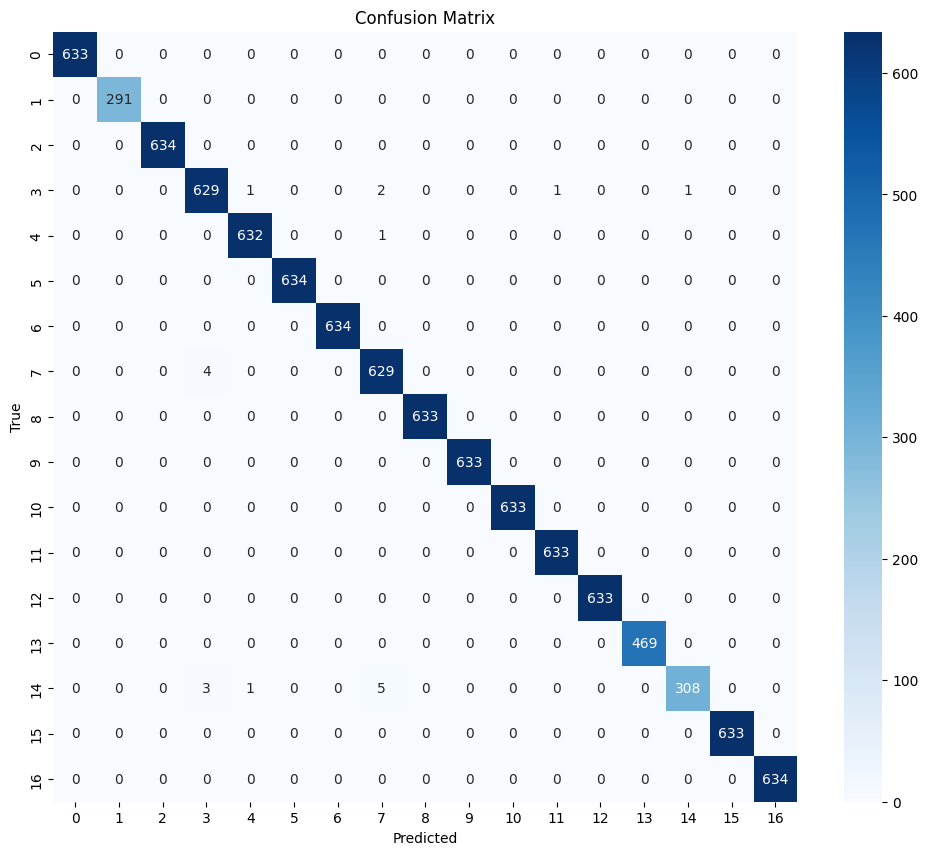

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       633
           1       1.00      1.00      1.00       291
           2       1.00      1.00      1.00       634
           3       0.99      0.99      0.99       634
           4       1.00      1.00      1.00       633
           5       1.00      1.00      1.00       634
           6       1.00      1.00      1.00       634
           7       0.99      0.99      0.99       633
           8       1.00      1.00      1.00       633
           9       1.00      1.00      1.00       633
          10       1.00      1.00      1.00       633
          11       1.00      1.00      1.00       633
          12       1.00      1.00      1.00       633
          13       1.00      1.00      1.00       469
          14       1.00      0.97      0.98       317
          15       1.00      1.00      1.00       633
          16       1.00      1.00      1.00       634

    accuracy              

In [1]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 예측 결과 불러오기
df = pd.read_csv('../data/final_training_data/val_preds.csv')

# 2. 정답과 예측값 추출
y_true = df['target']
y_pred = df['pred']

# 3. Confusion Matrix 계산
cm = confusion_matrix(y_true, y_pred)

# 4. 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 5. 정확도, 정밀도, 재현율 등도 함께 보기
print(classification_report(y_true, y_pred))




✅ 비교적 약한 클래스

🔸 클래스 3
	•	634개 중 629개 맞춤 → 5개 오답
	•	클래스 7, 8, 11, 13으로 잘못 분류됨
	•	→ 이 클래스는 다른 문서와 헷갈릴 여지가 조금 있음
	•	대응: 클래스 3의 유사 클래스 샘플을 따로 비교 시각화해보기

🔸 클래스 7
	•	633개 중 629개 정답 → 4개 오답
	•	클래스 3으로 4개 잘못 예측
	•	→ 클래스 3과 서로 헷갈리는 관계

✅ 가장 문제 있는 클래스: 클래스 14
	•	308개 맞춤, 9개 오답
	•	오답 분포: 클래스 4 (3건), 5 (1건), 10 (5건)
	•	→ 다른 클래스에 비해 상대적으로 분류가 불안정


결론
1. 클래스 3, 7은 약간 헷갈림 
2. 클래스 14는 오답률 가장 높아서 보완하자 (증강, class weight 조정, focal loss 등 고려)


In [2]:
import pandas as pd

# 기존 학습 데이터 불러오기
df_train = pd.read_csv('../data/final_training_data/train_folds.csv')

# 증강된 클래스 14 데이터 불러오기
df_aug = pd.read_csv('../data/augmented_only/class14_augmented.csv')

# 경로 조정 (학습 스크립트에서 이미지 경로가 어떻게 지정되는지에 따라 맞춰야 함)
df_aug['ID'] = df_aug['ID'].apply(lambda x: f'class14_augmented/{x}')

# 데이터 합치기
df_merged = pd.concat([df_train, df_aug], ignore_index=True)

# 새롭게 저장
df_merged.to_csv('../data/final_training_data/train_folds_augmented.csv', index=False)
print(f'Saved merged CSV with {len(df_merged)} rows.')

Saved merged CSV with 30080 rows.


In [3]:
import pandas as pd

df = pd.read_csv("../data/final_training_data/train_aug14.csv")

# 1. 전체 개수
print("전체 개수:", len(df))

# 2. 고유한 ID 개수
print("고유 ID 개수:", df["ID"].nunique())

# 3. 중복된 ID 출력
duplicates = df[df.duplicated("ID", keep=False)]
print("\n중복된 항목 수:", len(duplicates))
print(duplicates.head())

전체 개수: 30080
고유 ID 개수: 30080

중복된 항목 수: 0
Empty DataFrame
Columns: [ID, target]
Index: []


In [4]:
import os
import pandas as pd

df = pd.read_csv('../data/final_training_data/train_aug14.csv')
image_dir = '../data/final_training_data/train'

missing = []

for id in df['ID']:
    image_path = os.path.join(image_dir, id)
    if not os.path.exists(image_path):
        missing.append(id)

print(f"Missing files: {len(missing)}")
print(missing[:10])  # 일부만 출력

Missing files: 250
['bbc6a1043212c631_aug_4.jpg', '5074e85e2a75a1fe_aug_4.jpg', 'e8cf8d1415370974_aug_3.jpg', '45ec22e6b1b60734_aug_0.jpg', 'ebbe01aaff327255_aug_4.jpg', 'c323c86de8033ad1_aug_2.jpg', '2e3550bead1a72cb_aug_1.jpg', '0f3ac436363ae727_aug_3.jpg', 'e8cf8d1415370974_aug_2.jpg', '04320d1d34f005ca_aug_0.jpg']


In [5]:

csv_path = '../data/final_training_data/train_aug14.csv'
image_dir = '../data/final_training_data/train'

df = pd.read_csv(csv_path)
df_clean = df[df['ID'].apply(lambda x: os.path.exists(os.path.join(image_dir, x)))]

print(f"정상 이미지 수: {len(df_clean)}")

save_path = '../data/final_training_data/train_aug14_clean.csv'
df_clean.to_csv(save_path, index=False)
print(f"Saved to {save_path}")

정상 이미지 수: 29830
Saved to ../data/final_training_data/train_aug14_clean.csv


In [8]:

import pandas as pd
import torch
from sklearn.utils.class_weight import compute_class_weight

df = pd.read_csv('../data/final_training_data/train_aug14_clean.csv')
classes = df['target'].values
class_weights = compute_class_weight(class_weight='balanced', classes=sorted(set(classes)), y=classes)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# 저장해두기
torch.save(class_weights, '../class_weights.pth')
print(class_weights)

tensor([0.9235, 2.0077, 0.9235, 0.9235, 0.9235, 0.9235, 0.9235, 0.9235, 0.9235,
        0.9235, 0.9235, 0.9235, 0.9235, 1.2480, 1.8471, 0.9235, 0.9235])
